In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = utils.data_loader(path="../DATA/Gold Futures Historical Data.csv")
data.columns=["close_vgt", "open_vgt", "high_vgt", "low_vgt", "volume_vgt", "change%_vgt"]
missing_vals = len(pd.date_range(start="2009-01-01", end="2019-12-31", freq="B" ).difference(data.index))
print("Missing Values Gold", missing_vals)

Missing Values Gold 44


In [3]:
data = utils.data_loader(path="../DATA/VGT_historical data_2005.csv")
data.columns=["close_vgt", "open_vgt", "high_vgt", "low_vgt", "volume_vgt", "change%_vgt"]
missing_vals = len(pd.date_range(start="2009-01-01", end="2019-12-31", freq="B" ).difference(data.index))
print("Missing Values VGT", missing_vals)

data2 = utils.data_loader(path="../DATA/XSD Historical Data.csv")
data2.columns=["close_xsd", "open_xsd", "high_xsd", "low_xsd", "volume_xsd", "change%_xsd"]
missing_vals = len(pd.date_range(start="2009-01-01", end="2019-12-31", freq="B" ).difference(data2.index))
print("Missing Values XSD", missing_vals)


data = data.merge(data2, how= "left", left_on=data.index, right_on=data2.index, copy=False )
data.set_index("key_0", inplace=True)

sp = utils.data_loader(path="../DATA/S&P 500 Historical Data.csv")
sp.columns=["s&p500", "open_sp", "high_sp", "low_sp", "volume_sp", "change%_sp"]
sp.drop("volume_sp", axis=1, inplace=True)

data = data.merge(sp, how= "left", left_on=data.index, right_on=sp.index, copy=False )
data.set_index("key_0", inplace=True)
data.head()

Missing Values VGT 101
Missing Values XSD 101


,close_vgt,open_vgt,high_vgt,low_vgt,volume_vgt,change%_vgt,close_xsd,open_xsd,high_xsd,low_xsd,volume_xsd,change%_xsd,s&p500,open_sp,high_sp,low_sp,change%_sp
key_0,,,,,,,,,,,,,,,,,
2005-01-03,46.56,47.46,47.46,46.56,8300.0,-1.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,45.60,46.73,46.73,45.54,6400.0,-2.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,45.36,45.60,45.60,45.36,1900.0,-0.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,45.19,45.56,45.56,45.19,6800.0,-0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,45.22,45.25,45.27,44.95,2900.0,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 10 holiday (non-trading) days --> 11 years 
# https://www.nyse.com/markets/hours-calendars

In [5]:
len(data["2009-01-01":"2019-12-31"])

2768

In [5]:
data=data["2009-01-01":]

In [6]:
data.dropna(inplace=True)
data.replace(',','', regex=True, inplace=True)
data=data[data.columns].astype(np.float)

In [7]:
data.head(3)

,close_vgt,open_vgt,high_vgt,low_vgt,volume_vgt,change%_vgt,close_xsd,open_xsd,high_xsd,low_xsd,volume_xsd,change%_xsd,s&p500,open_sp,high_sp,low_sp,change%_sp
key_0,,,,,,,,,,,,,,,,,
2009-01-02,35.42,34.11,35.52,34.01,112910.0,4.02,12.58,12.05,12.58,12.05,5220.0,4.23,931.80,902.99,934.73,899.35,3.16
2009-01-05,35.40,35.16,35.85,35.00,218430.0,-0.06,12.69,12.63,12.84,12.45,7200.0,0.87,927.45,929.17,936.63,919.53,-0.47
2009-01-06,36.51,35.83,36.92,35.83,396380.0,3.14,13.45,12.91,13.47,12.91,3590.0,5.99,934.70,931.17,943.85,927.28,0.78


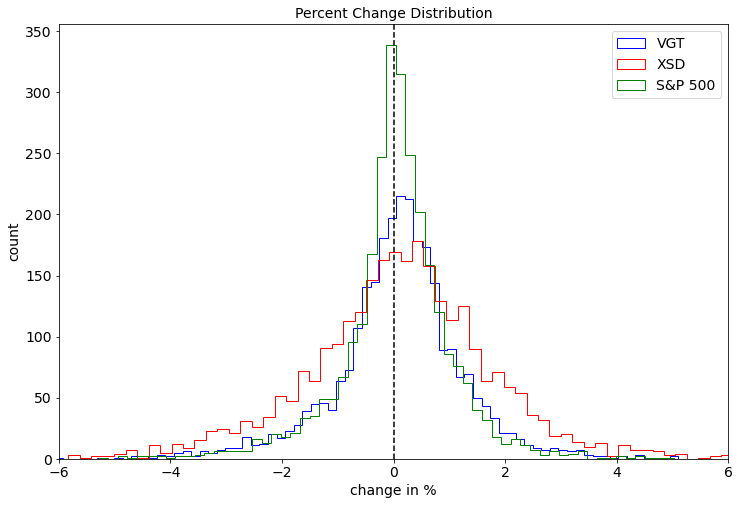

In [8]:
plt.figure(figsize=(12, 8))
plt.hist(data["change%_vgt"], bins = 80, histtype="step", color="b", linewidth=1, label="VGT")
plt.hist(data["change%_xsd"], bins=80, histtype="step", color="r", linewidth=1, label="XSD")
plt.hist(data["change%_sp"], bins=80, histtype="step", color="g", linewidth=1, label="S&P 500")
plt.title("Percent Change Distribution", fontsize=14)
plt.xlabel("change in %",  fontsize=14)
plt.ylabel("count",  fontsize=14)
plt.legend(fontsize=14)
plt.axvline(x=0.0, color='k', linestyle='--')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ticklabel_format(style='plain')
plt.xlim((-6,6))
plt.savefig("../../IMAGES/perc_chnage_dist_comparison")

# add trendline + s&p500

In [9]:
def pct_change(df, new_col_name, col):
    df[new_col_name] = 100 * (df[col]/df.iloc[0][col]-1)
    return df

pct_change(data, "total_pct_change_vgt", "close_vgt")
pct_change(data, "total_pct_change_xsd", "close_xsd")
pct_change(data, "total_pct_change_s&p500", "s&p500")

,close_vgt,open_vgt,high_vgt,low_vgt,volume_vgt,change%_vgt,close_xsd,open_xsd,high_xsd,low_xsd,volume_xsd,change%_xsd,s&p500,open_sp,high_sp,low_sp,change%_sp,total_pct_change_vgt,total_pct_change_xsd,total_pct_change_s&p500
key_0,,,,,,,,,,,,,,,,,,,,
2009-01-02,35.42,34.11,35.52,34.01,112910.0,4.02,12.58,12.05,12.58,12.05,5220.0,4.23,931.80,902.99,934.73,899.35,3.16,0.000000,0.000000,0.000000
2009-01-05,35.40,35.16,35.85,35.00,218430.0,-0.06,12.69,12.63,12.84,12.45,7200.0,0.87,927.45,929.17,936.63,919.53,-0.47,-0.056465,0.874404,-0.466838
2009-01-06,36.51,35.83,36.92,35.83,396380.0,3.14,13.45,12.91,13.47,12.91,3590.0,5.99,934.70,931.17,943.85,927.28,0.78,3.077357,6.915739,0.311226
2009-01-07,35.26,35.86,35.89,35.07,283090.0,-3.42,12.67,13.12,13.12,12.67,45360.0,-5.80,906.65,927.45,927.45,902.37,-3.00,-0.451722,0.715421,-2.699077
2009-01-08,35.56,35.23,35.59,34.82,258470.0,0.85,12.65,12.61,12.66,12.51,43330.0,-0.16,909.73,905.73,910.00,896.81,0.34,0.395257,0.556439,-2.368534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,243.85,244.10,244.24,243.27,234600.0,0.01,106.66,106.56,106.66,105.99,45270.0,0.32,3223.38,3225.45,3226.43,3220.51,-0.02,588.452851,747.853736,245.930457
2019-12-26,245.73,244.32,245.73,244.32,301470.0,0.77,107.44,106.91,107.44,106.48,73120.0,0.73,3239.91,3227.20,3240.08,3227.20,0.51,593.760587,754.054054,247.704443
2019-12-27,245.64,246.71,246.75,244.93,349470.0,-0.04,106.62,107.90,107.94,106.34,110600.0,-0.76,3240.02,3247.23,3247.93,3234.37,0.00,593.506494,747.535771,247.716248


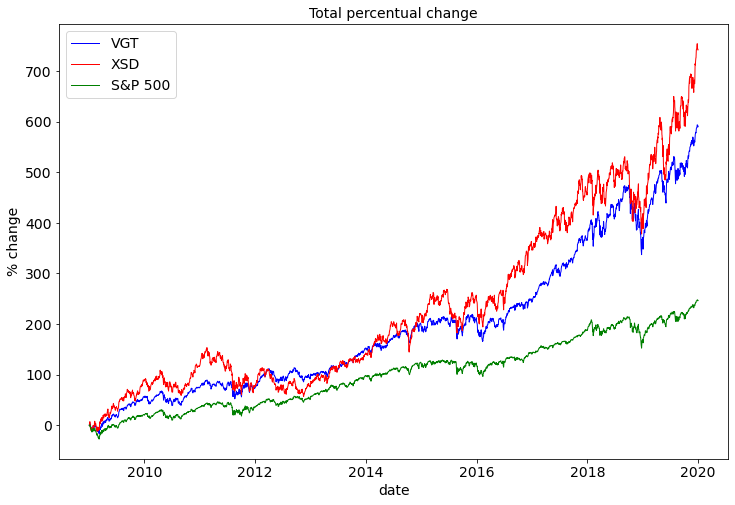

In [10]:
plt.figure(figsize=(12, 8))

plt.plot(data.index, data["total_pct_change_vgt"], color="b", label="VGT", linewidth=1)
plt.plot(data.index, data["total_pct_change_xsd"], color="r", label="XSD", linewidth=1)
plt.plot(data.index, data["total_pct_change_s&p500"], color="g", label="S&P 500", linewidth=1)

plt.legend(fontsize=14)
plt.xlabel("date", fontsize=14)
plt.ylabel("% change", fontsize=14)
plt.title("Total percentual change", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.savefig("../../IMAGES/total_change")

In [11]:
data["dispersion_vgt"] = (data.high_vgt-data.low_vgt)/data.close_vgt
data["dispersion_xsd"] = (data.high_xsd-data.low_xsd)/data.close_xsd
data["dispersion_sp"] = (data.high_sp-data.low_sp)/data["s&p500"]

In [12]:
summary= pd.DataFrame(columns=["first value", "last value", "mean", "min", "max", "std", "relative std", "total change (abs)", "total change (%)", "dispersion"], index=["VGT", "XSD", "S&P 500"])

summary_vgt = {"first value": data.close_vgt.iloc[0],
               "last value": data.close_vgt.iloc[-1], 
               "mean": round(data.close_vgt.mean(),2), 
               "min": round(data.close_vgt.min(),4), 
               "max": round(data.close_vgt.max(),4), 
               "std": round(data.close_vgt.std(), 2), 
               "relative std": round(data.close_vgt.std()/data.close_vgt.mean(),4), 
               "total change (%)": round(data.total_pct_change_vgt.iloc[-1]), 
               "total change (abs)":data.close_vgt.iloc[-1] - data.close_vgt.iloc[0],
               "dispersion": round(data.dispersion_vgt.mean(), 4), 
              }

summary_xsd = {"first value": data.close_xsd.iloc[0],
               "last value": data.close_xsd.iloc[-1], 
               "mean": round(data.close_xsd.mean(),2), 
               "min": round(data.close_xsd.min(),4), 
               "max": round(data.close_xsd.max(),4), 
               "std": round(data.close_xsd.std(), 2), 
               "relative std": round(data.close_xsd.std()/data.close_xsd.mean(),4),
               "total change (%)": round(data.total_pct_change_xsd.iloc[-1]),
               "total change (abs)":data.close_xsd.iloc[-1] - data.close_xsd.iloc[0],
               "dispersion": round(data.dispersion_xsd.mean(), 4), 
             }

summary_sp = {"first value": data["s&p500"].iloc[0],
               "last value": data["s&p500"].iloc[-1], 
              "mean": round(data["s&p500"].mean(),2), 
               "min": round(data["s&p500"].min(),4), 
               "max": round(data["s&p500"].max(),4), 
               "std": round(data["s&p500"].std(), 2), 
               "relative std": round(data["s&p500"].std()/data["s&p500"].mean(),4), 
               "total change (%)": round(data["total_pct_change_s&p500"].iloc[-1]),
              "total change (abs)":data["s&p500"].iloc[-1] - data["s&p500"].iloc[0],
              "dispersion": round(data.dispersion_sp.mean(), 4), 
              }

summary.loc["VGT"] = summary_vgt
summary.loc["XSD"] = summary_xsd
summary.loc["S&P 500"] = summary_sp
summary

,first value,last value,mean,min,max,std,relative std,total change (abs),total change (%),dispersion
VGT,35.42,244.85,105.48,29.36,245.73,51.86,0.4917,209.43,591.0,0.0133
XSD,12.58,105.89,42.07,11.04,107.44,22.1,0.5253,93.31,742.0,0.019
S&P 500,931.8,3230.78,1870.24,676.53,3240.02,633.76,0.3389,2298.98,247.0,0.0112


---
---
---